# Create a hetnet of genesets for automatic gene expression compression interpretation

This script was modified from https://github.com/dhimmel/integrate.

The script creates a hetnet as described in the eLIFE publication _"Systematic integration of biomedical knowledge prioritizes drugs for repurposing"_ by [Himmelstein et al. 2017](https://doi.org/10.7554/eLife.26726)

## Datasets

1. [MSigDb](https://doi.org/10.1073/pnas.0506580102 "Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles") - Curated genesets that represent various biological processes
2. [xCell](https://doi.org/10.1186/s13059-017-1349-1, "xCell: digitally portraying the tissue cellular heterogeneity landscape") - Curated genesets that describe profiles of different cell-types

In [1]:
# pip install seaborn


In [2]:
# pip install hetnetpy

In [3]:
import os
import csv
import pandas as pd
import seaborn as sns

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

In [4]:
%matplotlib inline

## Define the metagraph and instantiate the graph

In [5]:
kind_to_abbev = {
    
    # metanodes
    'Gene': 'G',

    # MSigDB Nodes
    'Cancer-Hallmarks': 'H',
    'Positional-Gene-Sets': 'C1',
    'Curated-Gene-Sets-CPG': 'C2CPG',
    'Curated-Gene-Sets-REACTOME': 'C2CPREACTOME',
    'Motif-Gene-Sets-MIR': 'C3MIR',
    'Motif-Gene-Sets-TFT': 'C3TFT',
    'Computational-Gene-Sets-CGN': 'C4CGN',
    'Computational-Gene-Sets-CM': 'C4CM',
    'GO-Gene-Sets-BP': 'C5BP',
    'GO-Gene-Sets-CC': 'C5CC',
    'GO-Gene-Sets-MF': 'C5MF',
    'Oncogenic-Gene-Sets': 'C6',
    'Immunologic-Gene-Sets': 'C7',
    'Cell-type-Gene-Sets' : 'C8',
    
    # xCell Nodes
    'xCell-Cell-Type': 'XCELL',
    
    # metaedges
    'participates': 'p',
}

metaedge_tuples = [
    # MSigDB metaedges
    ('Gene', 'Cancer-Hallmarks', 'participates', 'both'),
    ('Gene', 'Positional-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Curated-Gene-Sets-CPG', 'participates', 'both'),
    ('Gene', 'Curated-Gene-Sets-REACTOME', 'participates', 'both'),
    ('Gene', 'Motif-Gene-Sets-MIR', 'participates', 'both'),
    ('Gene', 'Motif-Gene-Sets-TFT', 'participates', 'both'),
    ('Gene', 'Computational-Gene-Sets-CGN', 'participates', 'both'),
    ('Gene', 'Computational-Gene-Sets-CM', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-BP', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-CC', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-MF', 'participates', 'both'),
    ('Gene', 'Oncogenic-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Immunologic-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Cell-type-Gene-Sets', 'participates', 'both'),
    
    # xCell metaedges
    ('Gene', 'xCell-Cell-Type', 'participates', 'both'),
]

In [6]:
# Initialize the graph
metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

## Gene Nodes

In [7]:
# Load curated gene names from versioned resource 
commit = '721204091a96e55de6dcad165d6d8265e67e2a48'
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/genes.tsv'.format(commit)
gene_df = pd.read_table(url)

# Only consider protein-coding genes
gene_df = (
    gene_df.query("gene_type == 'protein-coding'")
)

coding_genes = set(gene_df['entrez_gene_id'].astype(int))
print(gene_df.shape)
gene_df.head(2)

(20703, 7)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,1,A1BG,alpha-1-B glycoprotein,19,protein-coding,A1B|ABG|GAB|HYST2477,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...
1,2,A2M,alpha-2-macroglobulin,12,protein-coding,A2MD|CPAMD5|FWP007|S863-7,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...


## Add genes as nodes to the graph

Use the gene-symbol identifier for easier interpretation

In [8]:
%%time
for i, row in gene_df.iterrows():
    # Build dictionary of descriptive elements for each gene
    meta_data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row['entrez_gene_id']),
        'license': 'CC0 1.0',
    }
    
    if pd.notnull(row['chromosome']):
        meta_data['chromosome'] = row['chromosome']

    # Add genes to graph
    graph.add_node(kind='Gene', identifier=int(row['entrez_gene_id']), name=row['symbol'],
                   data=meta_data)

CPU times: user 682 ms, sys: 8.48 ms, total: 691 ms
Wall time: 690 ms


In [9]:
# Load gene updater
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/updater.tsv'.format(commit)
updater_df = pd.read_table(url)
old_to_new_entrez = dict(zip(updater_df.old_entrez_gene_id,
                             updater_df.new_entrez_gene_id))

## Add gene set nodes and associated genes as edges

Add each MSigDB collection as distinct nodes with a `participates` edge for representative gene sets and corresponding membership.

In [10]:
def add_node_to_graph(current_graph, collection_file, collection_kind,
                      collection_source, gene_list, min_geneset_size=4,
                      max_geneset_size=1000, license='CC BY 4.0'):
    """
    Add nodes and edges to current graph based on geneset memembership of collection
    
    Arguments:
    current_graph - a hetnet object to add node-edge info to
    collection_file - location of msigdb file
    collection_kind - the kind of node already initialized in the graph
    collection_source - alternative ID for collection
    gene_list - a list of genes to consider when building the graph
    min_geneset_size - filter out a given gene set if it has fewer genes
    max_geneset_size - filter out a given gene set if it has more genes
    license - given license associated with node
    
    Output:
    Adds to current graph; Returns the amount of filtered genesets
    """
    
    # Build meta data dictionary to store node info
    meta_data = {'license': license, 'source': collection_source}
    
    # Open the .gmt file and process each geneset
    filtered_genesets = []
    with open(collection_file, 'r') as collection_fh:
        collection_reader = csv.reader(collection_fh, delimiter='\t')

        for row in collection_reader:
            # Get geneset and and metadata info
            geneset_name = row[0]
            meta_data['url'] = row[1]
            
            # Process geneset membership
            genes = row[2:]

            # Update entrez_gene_id
            genes = set(old_to_new_entrez[x] if x in old_to_new_entrez else x for x in genes)
            
            # The genes must exist in curated resource
            genes = [int(x) for x in genes if int(x) in gene_list]

            # Filter geneset if its too big or small
            if min_geneset_size > len(genes) or len(genes) > max_geneset_size:
                filtered_genesets.append(geneset_name)
                continue
                
            # Add the genesetname as a node (based on collection) to the graph
            current_graph.add_node(kind=collection_kind,
                                   identifier=geneset_name,
                                   data=meta_data)
            # Loop through all genes and add to the graph it should be considered
            for gene in genes:
                source_id = ('Gene', gene)
                target_id = (collection_kind, geneset_name)
                edge_data = meta_data.copy()
                current_graph.add_edge(source_id, target_id, 'participates',
                                       'both', edge_data)

    return filtered_genesets

In [11]:
hetnet_build = {
    # Format: `Collection Source`: [`Collection File`, `Collection Kind`]

    # MSigDB
    'MSigDB-H': ['h.all.v7.5.entrez.gmt', 'Cancer-Hallmarks'],
    'MSigDB-C1': ['c1.all.v7.5.entrez.gmt', 'Positional-Gene-Sets'],
    'MSigDB-C2-CPG': ['c2.cgp.v7.5.entrez.gmt', 'Curated-Gene-Sets-CPG'],
    'MSigDB-C2-Reactome': ['c2.cp.reactome.v7.5.entrez.gmt', 'Curated-Gene-Sets-REACTOME'],
    'MSigDB-C3-MIR': ['c3.mir.v7.5.entrez.gmt', 'Motif-Gene-Sets-MIR'],
    'MSigDB-C3-TFT': ['c3.tft.v7.5.entrez.gmt', 'Motif-Gene-Sets-TFT'],
    'MSigDB-C4-CGN': ['c4.cgn.v7.5.entrez.gmt', 'Computational-Gene-Sets-CGN'],
    'MSigDB-C4-CM': ['c4.cm.v7.5.entrez.gmt', 'Computational-Gene-Sets-CM'],
    'MSigDB-C5-BP': ['c5.go.bp.v7.5.entrez.gmt', 'GO-Gene-Sets-BP'],
    'MSigDB-C5-CC': ['c5.go.cc.v7.5.entrez.gmt', 'GO-Gene-Sets-CC'],
    'MSigDB-C5-MF': ['c5.go.mf.v7.5.entrez.gmt', 'GO-Gene-Sets-MF'],
    'MSigDB-C6': ['c6.all.v7.5.entrez.gmt', 'Oncogenic-Gene-Sets'],
    'MSigDB-C7': ['c7.all.v7.5.entrez.gmt', 'Immunologic-Gene-Sets'],
    'MSigDB-C8': ['c8.all.v7.5.entrez.gmt', 'Cell-type-Gene-Sets'],
    
    # xCell
    'xCell-X': ['xcell_all_entrez.gmt', 'xCell-Cell-Type'],

}

In [12]:
%%time

# Add all collections genesets to hetnet
filtered = {}
for collection_source, collection_info in hetnet_build.items():
    path, collection_kind = collection_info
    collection_file = os.path.join('data_v7.5', path)
    filtered[collection_kind] = add_node_to_graph(current_graph=graph,
                                                  collection_file=collection_file,
                                                  collection_kind=collection_kind,
                                                  collection_source=collection_source,
                                                  gene_list=coding_genes)

CPU times: user 26.5 s, sys: 431 ms, total: 26.9 s
Wall time: 27 s


## Network visualizations and stats

In [15]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 251 kB 7.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Export node degree tables
node_degree_file = os.path.join('results', 'interpret_node_degrees.xlsx')
hetnetpy.stats.degrees_to_excel(graph, node_degree_file)

In [18]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetnetpy.stats.get_metanode_df(graph)

metanode_file = os.path.join('results', 'interpret_metanode_summary.tsv')
metanode_df.to_csv(metanode_file, sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
1,Cancer-Hallmarks,H,1,50,0
14,Cell-type-Gene-Sets,C8,1,693,0
7,Computational-Gene-Sets-CGN,C4CGN,1,427,0
8,Computational-Gene-Sets-CM,C4CM,1,431,0
3,Curated-Gene-Sets-CPG,C2CPG,1,3355,0
4,Curated-Gene-Sets-REACTOME,C2CPREACTOME,1,1611,0
9,GO-Gene-Sets-BP,C5BP,1,7533,0
10,GO-Gene-Sets-CC,C5CC,1,985,0
11,GO-Gene-Sets-MF,C5MF,1,1719,0
0,Gene,G,15,20703,1288


In [20]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    rows.append({'metaedge': str(metaedge)})

metaedge_file = os.path.join('results', 'interpret_metaedges.tsv')
metaedge_df = metaedge_df.merge(pd.DataFrame(rows))

sum_total = metaedge_df.sum()
sum_total.metaedge = 'Total'
sum_total.abbreviation = ''

metaedge_df = (
    pd.concat([metaedge_df.T, sum_total], axis='columns')
    .transpose()
    .reset_index(drop=True)
)
# Number of edges in the network
metaedge_df.edges.sum()

metaedge_df.to_csv(metaedge_file, sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
0,Gene - participates - Cancer-Hallmarks,GpH,7316,4378,50
1,Gene - participates - Cell-type-Gene-Sets,GpC8,104177,15012,693
2,Gene - participates - Computational-Gene-Sets-CGN,GpC4CGN,42108,4839,427
3,Gene - participates - Computational-Gene-Sets-CM,GpC4CM,48218,8255,431
4,Gene - participates - Curated-Gene-Sets-CPG,GpC2CPG,338674,18086,3355
5,Gene - participates - Curated-Gene-Sets-REACTOME,GpC2CPREACTOME,82629,10214,1611
6,Gene - participates - GO-Gene-Sets-BP,GpC5BP,476873,15771,7533
7,Gene - participates - GO-Gene-Sets-CC,GpC5CC,70535,11796,985
8,Gene - participates - GO-Gene-Sets-MF,GpC5MF,81979,14065,1719
9,Gene - participates - Immunologic-Gene-Sets,GpC7,965263,18383,5207


In [21]:
# Summary of different styles for representing each metaedge
metaedge_style_file = os.path.join('results', 'interpret_metaedge_styles.tsv')
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.to_csv(metaedge_style_file, sep='\t', index=False)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
1,Cancer-Hallmarks - participates - Gene,Cancer-Hallmarks–participates–Gene,Gene - participates - Cancer-Hallmarks,HpG,GpH,Cancer-Hallmarks,Gene,1
27,Cell-type-Gene-Sets - participates - Gene,Cell-type-Gene-Sets–participates–Gene,Gene - participates - Cell-type-Gene-Sets,C8pG,GpC8,Cell-type-Gene-Sets,Gene,1
13,Computational-Gene-Sets-CGN - participates - Gene,Computational-Gene-Sets-CGN–participates–Gene,Gene - participates - Computational-Gene-Sets-CGN,C4CGNpG,GpC4CGN,Computational-Gene-Sets-CGN,Gene,1
15,Computational-Gene-Sets-CM - participates - Gene,Computational-Gene-Sets-CM–participates–Gene,Gene - participates - Computational-Gene-Sets-CM,C4CMpG,GpC4CM,Computational-Gene-Sets-CM,Gene,1
5,Curated-Gene-Sets-CPG - participates - Gene,Curated-Gene-Sets-CPG–participates–Gene,Gene - participates - Curated-Gene-Sets-CPG,C2CPGpG,GpC2CPG,Curated-Gene-Sets-CPG,Gene,1
7,Curated-Gene-Sets-REACTOME - participates - Gene,Curated-Gene-Sets-REACTOME–participates–Gene,Gene - participates - Curated-Gene-Sets-REACTOME,C2CPREACTOMEpG,GpC2CPREACTOME,Curated-Gene-Sets-REACTOME,Gene,1
17,GO-Gene-Sets-BP - participates - Gene,GO-Gene-Sets-BP–participates–Gene,Gene - participates - GO-Gene-Sets-BP,C5BPpG,GpC5BP,GO-Gene-Sets-BP,Gene,1
19,GO-Gene-Sets-CC - participates - Gene,GO-Gene-Sets-CC–participates–Gene,Gene - participates - GO-Gene-Sets-CC,C5CCpG,GpC5CC,GO-Gene-Sets-CC,Gene,1
21,GO-Gene-Sets-MF - participates - Gene,GO-Gene-Sets-MF–participates–Gene,Gene - participates - GO-Gene-Sets-MF,C5MFpG,GpC5MF,GO-Gene-Sets-MF,Gene,1
0,Gene - participates - Cancer-Hallmarks,Gene–participates–Cancer-Hallmarks,Gene - participates - Cancer-Hallmarks,GpH,GpH,Gene,Cancer-Hallmarks,0


In [22]:
# How many genesets were filtered per collection?
{x: len(y) for x, y in filtered.items()}

{'Cancer-Hallmarks': 0,
 'Positional-Gene-Sets': 7,
 'Curated-Gene-Sets-CPG': 28,
 'Curated-Gene-Sets-REACTOME': 4,
 'Motif-Gene-Sets-MIR': 3,
 'Motif-Gene-Sets-TFT': 103,
 'Computational-Gene-Sets-CGN': 0,
 'Computational-Gene-Sets-CM': 0,
 'GO-Gene-Sets-BP': 125,
 'GO-Gene-Sets-CC': 21,
 'GO-Gene-Sets-MF': 19,
 'Oncogenic-Gene-Sets': 0,
 'Immunologic-Gene-Sets': 12,
 'Cell-type-Gene-Sets': 7,
 'xCell-Cell-Type': 0}

## Save graph

In [26]:
%%time
# Write nodes to a table
nodes_file = os.path.join('hetnets', 'interpret_nodes.tsv')
hetnetpy.readwrite.write_nodetable(graph, nodes_file)

# Write edges to a table
edges_file = os.path.join('hetnets', 'interpret_edges.sif.gz')
hetnetpy.readwrite.write_sif(graph, edges_file)

CPU times: user 9.26 s, sys: 17.9 ms, total: 9.28 s
Wall time: 9.33 s


In [28]:
%%time
# Write metagraph as json
metagraph_file = os.path.join('hetnets', 'interpret_metagraph.json')
hetnetpy.readwrite.write_metagraph(metagraph, metagraph_file)

CPU times: user 1.37 ms, sys: 1.17 ms, total: 2.54 ms
Wall time: 2.15 ms


In [29]:
%%time
# Write graph as json
hetnet_json_path = os.path.join('hetnets', 'interpret_hetnet.json.bz2')
hetnetpy.readwrite.write_graph(graph, hetnet_json_path)

CPU times: user 2min 23s, sys: 858 ms, total: 2min 23s
Wall time: 2min 24s


In [39]:
! sha256sum 'hetnets/interpret_hetnet.json.bz2'

b92f95627872a4a349f70dc9cdd047f6fcc02b71a2a24d12c9f7b83d9304ceda  hetnets/interpret_hetnet.json.bz2


## Visualize hetnet node and edge counts

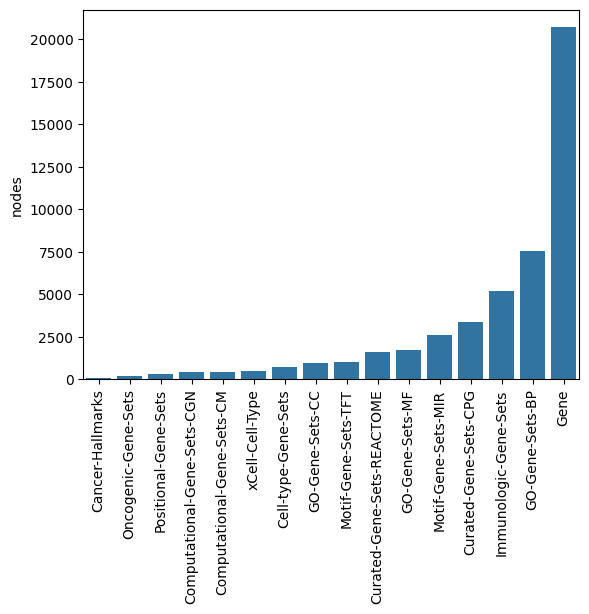

In [40]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

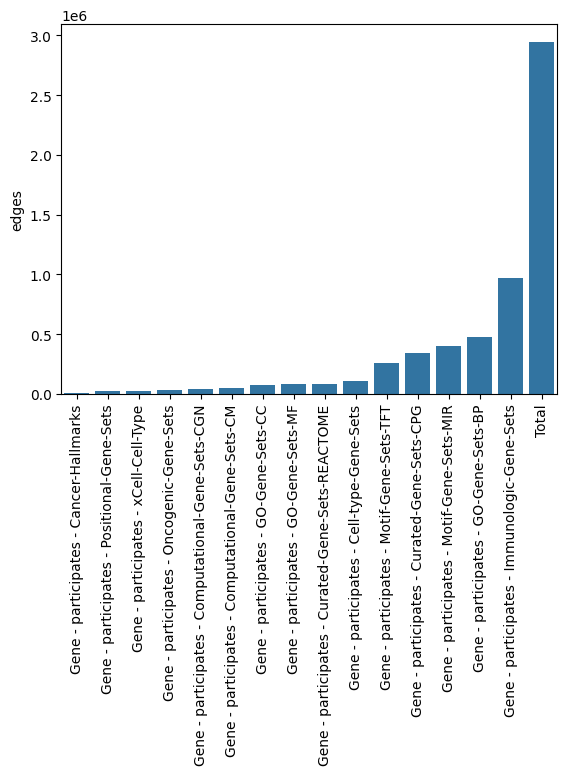

In [41]:
ax = sns.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');